In [1]:
import requests
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pathlib
import tarfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-03 19:08:49.811417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
r = requests.get(url, allow_redirects=True)
open("cora.tgz", "wb").write(r.content)

168052

In [3]:
tarball_path = pathlib.Path("datasets/housing.tgz")
if not tarball_path.is_file():
    pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
    with tarfile.open("cora.tgz") as datafile:
        datafile.extractall(path="datasets")
citationdata = pd.read_csv(pathlib.Path("datasets/cora/cora.cites"), sep="\t",header=None, names=["target", "source"],)
citationdata.sample(frac=1)

,target,source
1871,12359,242637
4779,289945,48550
3475,65074,1110209
4357,164885,447224
4670,242637,1113541
...,...,...
139,35,634904
4725,264347,1153183
168,40,116552
3619,74749,10186


In [4]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
paperdata = pd.read_csv(pathlib.Path("datasets/cora/cora.content"), sep="\t", header=None, names=column_names,)
paperdata.shape

(2708, 1435)

In [5]:
paperdata.sample(20)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
1217,17821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
1433,248119,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Theory
474,211875,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1500,463825,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
729,87915,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
2146,1108167,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
1760,1126037,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
691,55968,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
1424,577331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1456,148399,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


In [6]:
paperdata[["subject"]].value_counts()

subject               
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

In [7]:
class_values = sorted(paperdata["subject"].unique())
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [8]:
class_idx = {name: id for id, name in enumerate(class_values)}
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [9]:
paper_idx = {name: idx for idx, name in enumerate(sorted(paperdata["paper_id"].unique()))}
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

In [10]:
paperdata["paper_id"] = paperdata["paper_id"].apply(lambda name: paper_idx[name])
paperdata["subject"] = paperdata["subject"].apply(lambda value: class_idx[value])
citationdata["source"] = citationdata["source"].apply(lambda name: paper_idx[name])
citationdata["target"] = citationdata["target"].apply(lambda name: paper_idx[name])

In [11]:
paperdata.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [12]:
plt.figure(figsize=(10,10))
colors = paperdata["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citationdata.sample(n=150))
subjects = list(paperdata[paperdata["paper_id"].isin(list(cora_graph.nodes))]["subject"])
subjects

[4,
 2,
 2,
 1,
 2,
 2,
 3,
 4,
 2,
 0,
 3,
 0,
 6,
 6,
 4,
 3,
 6,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 5,
 0,
 2,
 3,
 6,
 2,
 2,
 3,
 3,
 4,
 2,
 6,
 0,
 5,
 3,
 3,
 3,
 3,
 5,
 2,
 3,
 1,
 1,
 3,
 2,
 3,
 5,
 2,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 4,
 1,
 2,
 2,
 6,
 6,
 6,
 6,
 4,
 3,
 4,
 4,
 2,
 6,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 6,
 5,
 1,
 2,
 6,
 2,
 1,
 6,
 2,
 1,
 2,
 0,
 3,
 2,
 2,
 4,
 1,
 0,
 0,
 0,
 2,
 6,
 2,
 4,
 3,
 3,
 3,
 2,
 2,
 1,
 5,
 1,
 3,
 2,
 0,
 3,
 6,
 6,
 6,
 2,
 2,
 2,
 6,
 3,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 3,
 5,
 2,
 4,
 1,
 6,
 6,
 3,
 2,
 2,
 5,
 6,
 3,
 3,
 2,
 5,
 6,
 5,
 2,
 2,
 3,
 3,
 1,
 3,
 6,
 4,
 6,
 4,
 2,
 5,
 2,
 3,
 1,
 2,
 3,
 2,
 2,
 0,
 6,
 2,
 3,
 0,
 3,
 6,
 2,
 4,
 1,
 4,
 2,
 3,
 3,
 2,
 5,
 5,
 4,
 1,
 2,
 2,
 2,
 3,
 2,
 6,
 3,
 2,
 2,
 2,
 2,
 5,
 6,
 4,
 0,
 6,
 6,
 0,
 2,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 2,
 5,
 4,
 1,
 2,
 3,
 6,
 6,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 6,
 1,
 1,
 1,
 4,
 0,
 3,
 6,
 6,
 6,


<Figure size 1000x1000 with 0 Axes>

ValueError: Received invalid argument(s): node_colour

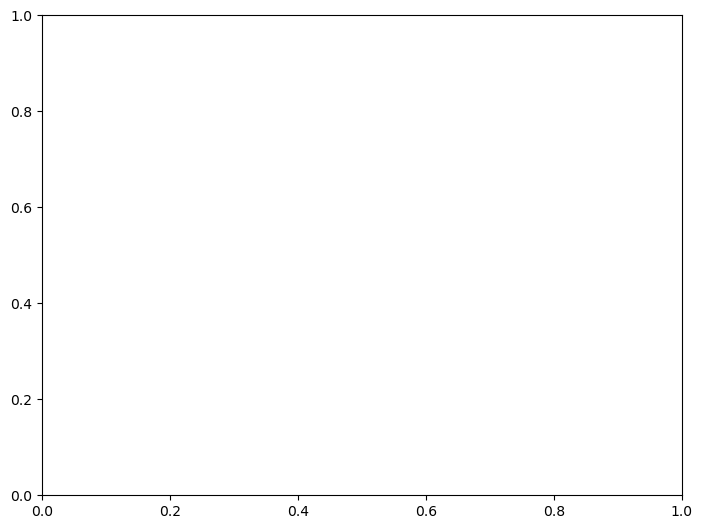

In [13]:
nx.draw_spring(cora_graph, node_size = 15, node_colour = subjects)

In [ ]:
nx.drawing.layout.spring_layout(cora_graph)

{2587: array([ 0.24000092, -0.75043033]),
 972: array([ 0.2587069 , -0.75707678]),
 737: array([0.37454997, 0.84089467]),
 31: array([0.35612621, 0.81374543]),
 2681: array([0.25857941, 0.8115436 ]),
 1567: array([0.26657897, 0.84376019]),
 1640: array([ 0.81714809, -0.38886807]),
 605: array([ 0.78242637, -0.37288834]),
 1138: array([ 0.19839784, -0.911172  ]),
 282: array([ 0.21200931, -0.89666415]),
 1601: array([-0.87620018, -0.22689984]),
 780: array([-0.83943349, -0.21862254]),
 1983: array([0.70455961, 0.56593158]),
 461: array([0.67656672, 0.54211802]),
 1256: array([-0.85299612,  0.42106967]),
 1257: array([-0.86601373,  0.39540395]),
 2664: array([-0.15626077, -0.7432366 ]),
 779: array([-0.13771343, -0.73687847]),
 638: array([-0.70932754, -0.57961688]),
 49: array([-0.73250181, -0.59749714]),
 662: array([ 0.35113972, -0.85938778]),
 153: array([ 0.3363482 , -0.81982437]),
 1577: array([ 0.51129781, -0.66828162]),
 1252: array([ 0.53742459, -0.70936241]),
 2540: array([ 0.8

In [ ]:
paperdata.groupby("subject")

In [ ]:
train_data, test_data = [], []

for _, group_data in paperdata.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2154, 1435)
Test data shape: (554, 1435)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256